In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pickle as pkl
import os.path
from rasterio.mask import mask
import folium
from multiprocess import Pool
import plotly.express as px
from shapely.geometry import Point, mapping
import plotly.graph_objects as go
from matplotlib import cm
from folium import plugins
from rasterio.enums import Resampling
import scipy
from rasterio.io import MemoryFile
import itertools
import geopandas as gpd
import gc
from tqdm.notebook import tqdm
from shapely.ops import transform
import pyproj

In [2]:
src = rasterio.open('4326/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0.tif')
print(src.crs)
prof = src.profile
pop_transform = src.transform
print(prof["height"], prof["width"])
# pop = src.read(1)

EPSG:4326
21600 43200


In [3]:
prof

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -200.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333333333333, 0.0, -180.0,
       0.0, -0.008333333333333333, 90.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [4]:
country_shp = gpd.read_file("countries/world_countries_2020.shp")
# print(country_shp.shape)
# country_shp.head()

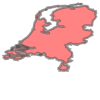

In [5]:
country_dict = country_shp[["CNTRY_NAME", "geometry"]].set_index("CNTRY_NAME").to_dict()["geometry"]
country_dict["Netherlands"]

In [6]:
country_shp["CNTRY_NAME"].unique()

array(['Algeria', 'Angola', 'In dispute South Sudan/Sudan', 'Benin',
       'Botswana', 'Burkina Faso', 'Burundi', 'Bouvet I.', 'Cameroon',
       'Cape Verde', 'Central African Republic', 'Chad', 'Comoros',
       'Egypt', 'Mayotte', 'Nigeria', 'Seychelles', 'Congo', 'Congo, DRC',
       "Cote d'Ivoire", 'Djibouti', 'Equatorial Guinea', 'Eritrea',
       'Ethiopia', 'French Southern & Antarctic Lands', 'Gabon', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'Heard I. & McDonald Is.',
       'In dispute Benin/Burkina Faso',
       'In dispute Comoros/Mayotte/Madagascar',
       'In dispute Djibouti/Eritrea', 'In dispute Egypt/Saudi Arabia',
       'In dispute Equatorial Guinea/Gabon', 'Kenya', 'Lesotho',
       'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Rwanda',
       'Reunion', 'Sao Tome & Principe', 'Senegal', 'Sierra Leone',
       'Somalia', 'Sudan', 'Tanzania', 'South Africa', 'South Sudan',
    

In [7]:
countries = ["Netherlands", "Belgium", "Luxembourg", "United Kingdom", "Sweden", "Finland", "Denmark", "France",
             "Spain", "Italy", "Austria", "Germany", "Switzerland", "Poland", "Israel", "Switzerland",
            "United States", "Canada", "Australia", "New Zealand", "Singapore", "Taiwan", "South Korea", "Japan",
            "United Arab Emirates"]

countries = ["Netherlands", "Belgium", "Luxembourg", "Sweden", "Finland", "Denmark", "France",
             "Spain", "Italy", "Austria", "Germany", "Poland", "Ireland", "Czech Republic", "Slovakia", 
            "Slovenia", "Bulgaria", "Greece", "Cyprus", "Malta", "Croatia", "Estonia", "Latvia", 
            "Lithuania", "Romania", "Hungary", "Portugal", "Faroe Is.",
            'In dispute Croatia/Slovenia']

# countries = ["Pakistan",
#             "In dispute India/Pakistan"]

# countries = ["United States", "Canada"]

In [8]:
for country in tqdm(countries):
    fname = "raggeds/ragged_" + country.replace("/", "_") + ".pkl"
    print(country)
    if not os.path.isfile(fname):
    
        mapping = [country_dict[country]]
        mask_data, _ = mask(src, mapping, crop=False)

        # positives = 
        sums = np.sum(mask_data.squeeze().clip(0), axis=1)
        idxs = [idx for idx, val in enumerate(sums) if val > 0]

        data_mat = mask_data.squeeze()
    #     partial_ragged = partial(get_ragged_i, data_mat)
    #     raggged = list(tqdm(p.imap(partial_ragged, list(range(data_mat.shape[0]))), total=data_mat.shape[0]))
        ragged = []

        for i in tqdm(range(data_mat.shape[0]), leave=False):
            ragged.append([])
            if i not in idxs:
                continue
            for j in range(data_mat.shape[1]):
                if data_mat[i][j] > -200:
                    ragged[i].append(j)

        del data_mat
        gc.collect()
        pkl.dump(ragged, open(fname, "wb"))

  0%|          | 0/29 [00:00<?, ?it/s]

Netherlands
Belgium
Luxembourg
Sweden
Finland
Denmark
France
Spain
Italy
Austria
Germany
Poland
Ireland
Czech Republic
Slovakia
Slovenia
Bulgaria
Greece
Cyprus
Malta
Croatia
Estonia
Latvia
Lithuania
Romania
Hungary
Portugal
Faroe Is.
In dispute Croatia/Slovenia


In [9]:
ragged = None
for country in tqdm(countries):
    fname = "raggeds/ragged_" + country.replace("/", "_") + ".pkl"
    country_ragged = pkl.load(open(fname, "rb"))
    if ragged is None:
        ragged = country_ragged
    else:
        for i in range(len(ragged)):
            ragged[i] = ragged[i] + country_ragged[i]

  0%|          | 0/29 [00:00<?, ?it/s]

In [10]:
# disp_rows = []
# disp_cols = set()
# for idx, i in (enumerate(ragged)):
#     if len(i):
#         disp_rows.append(idx)
#     for j in i:
#         disp_cols.add(j)

# disp_cols = sorted(list(disp_cols))

# plt.imshow(mask_data.squeeze()[min(disp_rows) - 10:max(disp_rows) + 10, min(disp_cols) - 10:max(disp_cols) + 10], 
#            origin="upper", interpolation="none", vmin=-200, vmax=1000)

In [11]:
tot = sum([len(x) for x in ragged])

print(tot, tot / (prof["height"] * prof["width"]))

7743138 0.008298115997942387


In [12]:
lens = [len(x) for x in ragged]

fig = go.Figure(data=go.Line(x=list(range(len(lens))), y=lens, mode='lines'))

fig.show()

C:\Users\j4fre\anaconda3\envs\mobility2\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  warnings.warn(


In [13]:
sums = [sum([lens[i] for i in range(j)]) for j in range(len(ragged))]
total = sum(lens)
norms = [x / total for x in sums]

fig = go.Figure(data=go.Line(x=list(range(len(lens))), y=norms, mode='lines'))

fig.show()

C:\Users\j4fre\anaconda3\envs\mobility2\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [14]:
def get_pop_rad(x, y, rad=40000):
    salz_pt = Point(y, x)

    wgs84 = pyproj.CRS('EPSG:4326')
    mercator = pyproj.CRS('EPSG:3857')

    project = pyproj.Transformer.from_crs(wgs84, mercator, always_xy=True).transform
    merc_point = transform(project, salz_pt)

    merc_buffer = merc_point.buffer(rad)

    reproject = pyproj.Transformer.from_crs(mercator, wgs84, always_xy=True).transform
    base_buffer = transform(reproject, merc_buffer)
    base_map = [salz_pt.buffer(0.3)]
    out_image, out_transform = mask(src, base_map, crop=True)
    return out_image.clip(0).sum()

def get_pop_rad_dict(point_dict, rad=40000):
    ret_dict = {}
    for city, coords in point_dict.items():
        pop_rad = get_pop_rad(coords[0], coords[1])
        ret_dict[city] = f"""{pop_rad:,}"""
    return ret_dict

In [15]:
city_dict = {
    "monash": (-37.9083, 145.138),
    "salzburg": (47.8, 13.033333),
    "oslo": (59.913889, 10.752222),
    "helsinki": (60.186111, 24.828611),
    "lawrence": (38.971667, -95.235278),
    "leuven": (50.883333, 4.7),
    "trondheim": (63.429722, 10.393333),
    "whitechapel": (51.5165, -0.075),
    "yerevan": (40.181389, 44.514444),
    "tbilisi": (41.7225, 44.7925),
    "purdue": (40.424, -86.929),
    "karlsruhe": (49.00921, 8.403951),
}

In [16]:
get_pop_rad_dict(city_dict)

{'monash': '3,299,298.553444785',
 'salzburg': '470,559.71578493086',
 'oslo': '1,004,486.396872068',
 'helsinki': '1,111,388.417330476',
 'lawrence': '150,083.57943264573',
 'leuven': '1,327,678.4021916664',
 'trondheim': '212,950.88392614422',
 'whitechapel': '8,663,247.547424909',
 'yerevan': '1,691,333.771575204',
 'tbilisi': '1,400,188.1255808447',
 'purdue': '201,950.00191950158',
 'karlsruhe': '1,113,863.80514745'}

In [17]:
p = Pool(9)

def get_map_obj(coords, rad=25000):
    from shapely.geometry import Point, mapping
    from shapely.ops import transform
    import pyproj
    x = coords[0]
    y = coords[1]
    salz_pt = Point(x, y)

    wgs84 = pyproj.CRS('EPSG:4326')
    mercator = pyproj.CRS('EPSG:3857')
    
#     buffer = salz_pt.buffer(0.3)
    
#     if 'EMPTY' in buffer.wkt:
#         return []
    
#     return [buffer]
    

    project = pyproj.Transformer.from_crs(wgs84, mercator, always_xy=True).transform
    merc_point = transform(project, salz_pt)

    merc_buffer = merc_point.buffer(rad)
    if 'EMPTY' in merc_buffer.wkt:
        return []

    reproject = pyproj.Transformer.from_crs(mercator, wgs84, always_xy=True).transform
    base_buffer = transform(reproject, merc_buffer)
    
    base_map = [base_buffer]
    return base_map

#     with rasterio.open("4326/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0.tif") as src:
#          out_image, out_transform = mask(src, base_map, crop=True)
#     return out_image.clip(0).sum()

# for i, js in tqdm(enumerate(ragged), total=len(ragged)):
# #     js = range(prof["width"])
#     partial_transform = partial(rasterio.transform.xy, pop_transform, i)
#     xys = p.map(partial_transform, js)
# #     break
#     map_objs = list(p.imap(get_map_obj, xys, chunksize=1))
# #     map_objs = list(map_objs)
    
#     for j_idx, j in enumerate(js):
#         map_obj = map_objs[j_idx]
#         if map_obj:
#             out_image, out_transform = mask(src, map_obj, crop=True)
#             pop_mat[i][j] = out_image.clip(0).sum()

for country in tqdm(countries):
    fname = "pops/pop_" + country.replace("/", "_") + ".pkl"
    ragged_fname = "raggeds/ragged_" + country.replace("/", "_") + ".pkl"
    ragged = pkl.load(open(ragged_fname, "rb"))
    pops = []

    if not os.path.isfile(fname):
        for i, js in tqdm(enumerate(ragged), total=len(ragged), leave=False, desc=country):
        #     js = range(prof["width"])
            partial_transform = partial(rasterio.transform.xy, pop_transform, i)
            xys = p.map(partial_transform, js)
        #     break
            map_objs = p.map(get_map_obj, xys, chunksize=1)

            for j_idx, j in enumerate(js):
                map_obj = map_objs[j_idx]
                if map_obj:
                    out_image, _ = mask(src, map_obj, crop=True)
        #             out_image = mask_raster_with_geometry(map_obj, crop=True)
        #             print(out_image.shape, out_image.clip(0).sum())
                    pops.append([i, j, out_image.clip(0).sum()])
        pkl.dump(pops, open(fname, "wb"))

        del pops
        del ragged
#         del out_image

  0%|          | 0/29 [00:00<?, ?it/s]

In [18]:
gc.collect()
pop_mat = np.ones((prof["height"], prof["width"]))
for country in tqdm(countries):
    fname = "pops/pop_" + country.replace("/", "_") + ".pkl"
    country_pop = pkl.load(open(fname, "rb"))
    for row in country_pop:
        pop_mat[row[0]][row[1]] = row[2]

  0%|          | 0/29 [00:00<?, ?it/s]

In [19]:
ragged = None
for country in tqdm(countries):
    fname = "raggeds/ragged_" + country.replace("/", "_") + ".pkl"
    country_ragged = pkl.load(open(fname, "rb"))
    if ragged is None:
        ragged = country_ragged
    else:
        for i in range(len(ragged)):
            ragged[i] = ragged[i] + country_ragged[i]

  0%|          | 0/29 [00:00<?, ?it/s]

In [20]:
pop_mat.min(), pop_mat.max()

(0.0, 7440502.06105516)

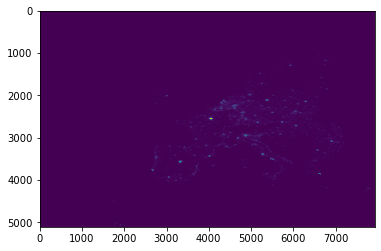

In [21]:
disp_rows = []
disp_cols = set()
for idx, i in (enumerate(ragged)):
    if len(i):
        disp_rows.append(idx)
    for j in i:
        disp_cols.add(j)

disp_cols = sorted(list(disp_cols))

plt.imshow(pop_mat[min(disp_rows) - 10:max(disp_rows) + 10, min(disp_cols) - 10:max(disp_cols) + 10], origin="upper", interpolation="none")

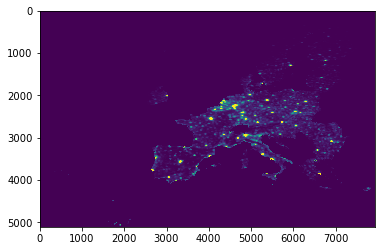

In [22]:
# live_mat = (pop_mat > 1000000).astype(int)
# live_mat = pop_mat.clip(-200, 1000000)

plt.imshow(pop_mat[min(disp_rows) - 10:max(disp_rows) + 10, min(disp_cols) - 10:max(disp_cols) + 10], 
           origin="upper", interpolation="none", vmin=-200, vmax=1000000)

In [23]:
# plt.imshow(mask_data.squeeze()[min(disp_rows) - 10:max(disp_rows) + 10, min(disp_cols) - 10:max(disp_cols) + 10], origin="upper", interpolation="none")

In [30]:
min_row = min(disp_rows)
min_col = min(disp_cols)
max_row = max(disp_rows)
max_col = max(disp_cols)

min_lon, min_lat = rasterio.transform.xy(pop_transform, max_row, min_col)
max_lon, max_lat = rasterio.transform.xy(pop_transform, min_row, max_col)

# if min_lon < 0:
#     min_lon = 360 + min_lon
# if max_lon < 0:
#     max_lon = 360 - max_lon
    
# if min_lon > max_lon:
#     t1 = max_lon
#     max_lon = min_lon
#     min_lon = t1

min_lat, max_lat, min_lon, max_lon

(27.645833333333336, 70.0875, -31.262500000000017, 34.587500000000006)

In [31]:
map_bounds = [[min_lat, min_lon], 
              [max_lat, max_lon]]

clipped = pop_mat.clip(-200, 1000000)[min(disp_rows):max(disp_rows),min(disp_cols):max(disp_cols)]

In [32]:
clipped.min(), clipped.max()

(0.0, 1000000.0)

In [33]:
normalized = clipped.clip(0) / 1000000 + (clipped < 0).astype(int) * -1
normalized.min(), normalized.max()

(0.0, 1.0)

In [34]:
m = folium.Map()

m.add_child(folium.raster_layers.ImageOverlay(normalized, 
                                              opacity=.5, 
                                              bounds=map_bounds,
                                                colormap = cm.viridis,
                                             mercator_project=True))

m

In [35]:
m.save('test_folium.html')